In [337]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
from plotnine import *

from scripts import get_img

from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [18]:
from sklearn.model_selection import train_test_split

In [295]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(restore_best_weights=True, patience=10)

def define_autoencoder(
        encoding_dim=3
        ,loss=tf.losses.mean_squared_error
        ,input_size=None
    ):

    inputLayer = tf.keras.layers.Input(shape=(input_size,))

    encoderLayer = tf.keras.layers.Dense(encoding_dim, activation='relu',use_bias = True)(inputLayer)

    outputLayer = tf.keras.layers.Dense(input_size, activation='linear',use_bias = True)(encoderLayer)

    
    autoencoder = tf.keras.models.Model(inputLayer, outputLayer)
    encoder = tf.keras.models.Model(inputLayer, encoderLayer)
    
    autoencoder.compile(loss=loss, optimizer = 'adam')
    
    return autoencoder, encoder

In [296]:
data = pd.read_csv('luminancias.csv')

In [297]:
autoencoder, encoder = define_autoencoder(encoding_dim=3, input_size=data.shape[1])

In [298]:
new_data = RobustScaler().fit_transform(data.values)

In [299]:
pd_new_data = data.copy()
pd_new_data.loc[:,:] = new_data

In [300]:
X_train, X_test = train_test_split(pd_new_data, train_size=0.6)

In [325]:
autoencoder.fit(pd_new_data, pd_new_data, batch_size=64, epochs=50, verbose=0)

In [326]:
len(autoencoder.history.history['loss'])

50

In [327]:
encoded_data = encoder.predict(pd_new_data)

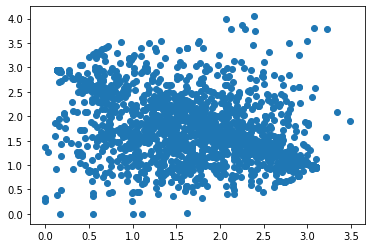

In [328]:
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])

In [397]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

In [399]:
tsvd_new_data = TruncatedSVD(n_components=3).fit_transform(pd_new_data)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
sc = ax.scatter(tsvd_new_data[:, 0], tsvd_new_data[:, 1], tsvd_new_data[:, 2], s=40, marker='o', alpha=1)

In [400]:
silhoutte = []
for n_clusters in tqdm(range(2,100)):
    clusterizer = KMeans(n_clusters=n_clusters)
    clusters = clusterizer.fit_predict(tsvd_new_data)
    
    transformed_data = pd.DataFrame(clusterizer.transform(tsvd_new_data))
    transformed_data['cluster'] = clusters
    transformed_data['bw'] = transformed_data.apply(lambda x: x[x['cluster']], axis=1)**2
    score = transformed_data.groupby('cluster')['bw'].sum().mean()
    
    silhoutte.append(score)

100%|██████████| 98/98 [02:04<00:00,  1.27s/it]


<AxesSubplot:>

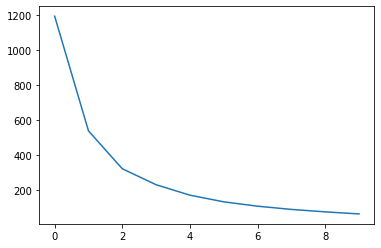

In [401]:
pd.Series(silhoutte)[:10].plot()

In [404]:
clusterizer = KMeans(n_clusters=6)
cp_data = data.copy()
cp_data['cluster'] = clusterizer.fit_predict(tsvd_new_data)

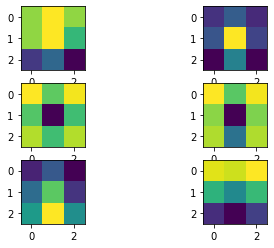

In [407]:
n_clusters = int(len(cp_data['cluster'].unique()))
dims = int(n_clusters/2), 2
fig, axs = plt.subplots(*dims)

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(cp_data.groupby('cluster').median().iloc[idx].values.reshape(3,3))

In [419]:
cp_data.groupby('cluster').sample(1)

,0,1,2,3,4,5,6,7,8,cluster
1175,127.0,199.0,174.0,114.0,206.0,143.0,74.0,151.0,145.0,0
582,71.0,49.0,70.0,74.0,60.0,69.0,75.0,61.0,74.0,1
673,243.0,243.0,247.0,244.0,244.0,246.0,246.0,246.0,247.0,2
377,230.0,230.0,230.0,106.0,80.0,130.0,224.0,223.0,224.0,3
736,99.0,102.0,108.0,106.0,114.0,110.0,118.0,135.0,127.0,4
1377,145.0,188.0,177.0,109.0,166.0,108.0,96.0,127.0,115.0,5


In [409]:
cam = glob.glob('../../../Osintgram/output/*.jpg')

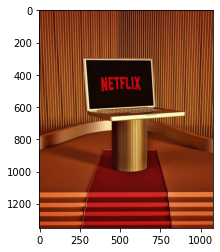

In [420]:
idx = 582
plt.imshow(get_img(cam[idx])[0])

In [289]:
axs

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [258]:
cp_data

,0,1,2,3,4,5,6,7,8,cluster
0,186.0,188.0,189.0,177.0,175.0,177.0,168.0,170.0,172.0,0
1,14.0,12.0,12.0,83.0,81.0,52.0,113.0,80.0,47.0,4
2,165.0,119.0,186.0,190.0,111.0,178.0,165.0,102.0,101.0,5
3,192.0,192.0,191.0,193.0,131.0,187.0,192.0,134.0,184.0,2
4,11.0,11.0,11.0,10.0,10.0,9.0,139.0,128.0,76.0,4
...,...,...,...,...,...,...,...,...,...,...
1532,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,3
1533,215.0,146.0,211.0,138.0,161.0,179.0,213.0,216.0,217.0,2
1534,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,3
1535,214.0,183.0,213.0,199.0,189.0,180.0,212.0,201.0,203.0,3


168.93224036628712

In [236]:
.apply(lambda x: x[clusters], axis=0)

,0,1,2,3,4,5,6,7,8
0,2.316457,0.136924,1.568757,3.945125,1.532815,1.193295,1.228409,1.307633,3.104287
1,1.590314,3.762699,5.169174,1.003731,2.725134,2.531704,4.260224,3.537429,1.965424
2,1.691539,1.432736,2.688012,3.174624,1.075818,1.207344,1.996754,0.929876,3.007440
3,2.330209,0.751043,1.757458,3.948362,1.523697,1.391972,1.115005,0.767765,3.404035
4,2.175030,4.329264,5.657571,1.547485,3.350760,3.117658,4.486963,4.026043,2.601024
...,...,...,...,...,...,...,...,...,...
1532,4.523499,2.144928,0.691423,6.143227,3.696691,3.321621,2.227405,2.988770,5.065080
1533,2.651817,1.041134,1.601291,4.248624,2.132815,1.599898,0.988116,1.559787,3.520278
1534,3.317288,0.955240,0.582809,4.938453,2.537460,2.121606,1.378986,1.963673,3.949973
1535,2.905041,0.669086,1.023276,4.532474,2.172771,1.748162,1.068663,1.581242,3.661967


In [256]:
pd.Series(clusters).value_counts()

0    373
3    273
1    271
5    246
4    212
2    162
dtype: int64

<ipython-input-52-a3f0543b2e6c>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


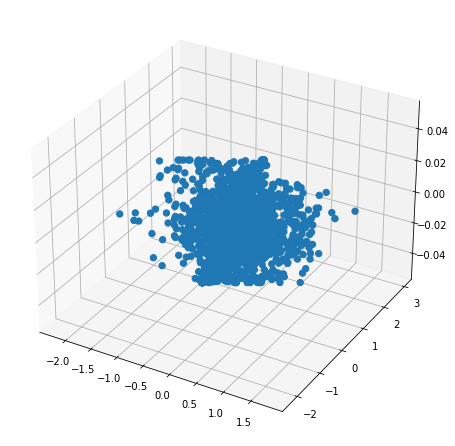

In [52]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
sc = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], s=40, marker='o', alpha=1)